In [1]:
import sys
sys.path.append("..")
%cd ..

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1


In [142]:
from scipy.stats import norm
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import r2_score, mean_squared_error
from DataPrep.load_data import load_data
from DataPrep.LagCreation import lags
from Tobit import Tobit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge


In [143]:
df = load_data()

In [144]:
l = lags()

In [145]:
testdata = df[df.Label == 0]


In [146]:
scaler_eng = StandardScaler()
scaler_fee = StandardScaler()
testdata["Energy (kWh)"] = scaler_eng.fit_transform(np.array(testdata["Energy (kWh)"]).reshape(-1,1))
testdata["Fee (USD)"] = scaler_fee.fit_transform(np.array(testdata["Fee (USD)"]).reshape(-1,1))


c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1\env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1\env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [147]:
testdata = testdata.drop(columns=["Charging Time (mins)","Parking Time (mins)",'# Professional & Other Places',
 '# Food',
 '# Shop & Service',
 '# Travel & Transport',
 '# Outdoors & Recreation',
 '# Arts & Entertainment',
 '# Nightlife Spot',
 '# Residence',
 '# College & University',
 '# Event',
 'Label_0',
 'Label_1',
 'Label_2',
 'Label_3',
 'Label_4',
 'Label_5',
 'Label_6',
 'Label_7'])

In [148]:
 testdata.columns

Index(['Label', 'Energy (kWh)', 'Fee (USD)', 'Plugs_raw',
       'Number of NEMA 5-20R_raw', 'Plugs', 'Number of NEMA 5-20R',
       'Month_Day_1', 'Month_Day_2', 'Month_Day_3', 'Month_Day_4',
       'Month_Day_5', 'Month_Day_6', 'Month_Day_7', 'Month_Day_8',
       'Month_Day_9', 'Month_Day_10', 'Month_Day_11', 'Month_Day_12',
       'Month_Day_13', 'Month_Day_14', 'Month_Day_15', 'Month_Day_16',
       'Month_Day_17', 'Month_Day_18', 'Month_Day_19', 'Month_Day_20',
       'Month_Day_21', 'Month_Day_22', 'Month_Day_23', 'Month_Day_24',
       'Month_Day_25', 'Month_Day_26', 'Month_Day_27', 'Month_Day_28',
       'Month_Day_29', 'Month_Day_30', 'Month_Day_31', 'Week_Day_0',
       'Week_Day_1', 'Week_Day_2', 'Week_Day_3', 'Week_Day_4', 'Week_Day_5',
       'Week_Day_6', 'Year_Month_1', 'Year_Month_2', 'Year_Month_3',
       'Year_Month_4', 'Year_Month_5', 'Year_Month_6', 'Year_Month_7',
       'Year_Month_8', 'Year_Month_9', 'Year_Month_10', 'Year_Month_11',
       'Year_Month_12', 'Ho

In [149]:
for i in range(1,13):
    testdata[f"Year_Month_{i}"] = 0
    testdata[f"Year_Month_{i}"][(testdata.index.month==i) & (testdata.index.day==1)] = 1
testdata[f"Year_Month_{testdata.index[0].month}"]=1

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1\env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1\env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1\env\lib\site-packag

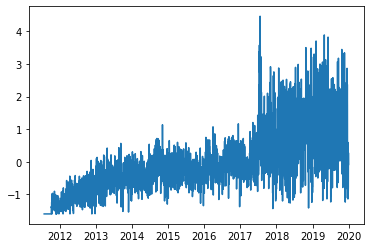

In [150]:
plt.plot(testdata["Energy (kWh)"])
plt.show()

In [151]:
def censor(s):
    energy = s["Energy (kWh)"] 
    energy_lag1 = s["Energy (kWh)_lag1"]
    energy_lag2 = s["Energy (kWh)_lag2"]
    energy_lag3 = s["Energy (kWh)_lag3"]
    energy_lag4 = s["Energy (kWh)_lag4"]
    energy_lag5 = s["Energy (kWh)_lag5"]

    s["Censored"] = False
    if energy > 0.5:
        s["Energy (kWh)"] = 0.5
        s["Censored"] = True
    if energy_lag1 > 0.5:
        s["Energy (kWh)_lag1"] = 0.5
    if energy_lag2 > 0.5:
        s["Energy (kWh)_lag2"] = 0.5
    if energy_lag3 > 0.5:
        s["Energy (kWh)_lag3"] = 0.5
    if energy_lag4 > 0.5:
        s["Energy (kWh)_lag4"] = 0.5
    if energy_lag5 > 0.5:
        s["Energy (kWh)_lag5"] = 0.5
    
    return s

In [152]:
testdata = l.buildLaggedFeatures(testdata,["Energy (kWh)"])

In [153]:
testdata = testdata.apply(censor, axis=1)

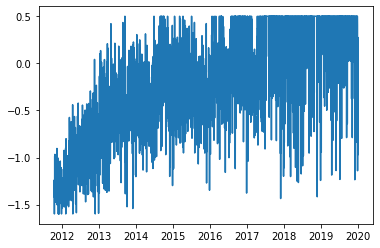

In [154]:
plt.plot(testdata["Energy (kWh)"])
plt.show()

In [155]:
testdata[testdata["Censored"] == False].shape

(2294, 66)

In [156]:
t = Tobit(testdata, 'Censored', list(testdata.drop(columns=["Energy (kWh)","Censored"]).columns), 'Energy (kWh)')

In [157]:
regressor = Ridge(fit_intercept=False).fit(testdata.drop(columns=["Energy (kWh)", "Censored"]), testdata["Energy (kWh)"])
pred = regressor.predict(testdata.drop(columns=["Energy (kWh)","Censored"]))

In [158]:
vars = regressor.coef_


In [159]:
vars = np.append(vars,1)

In [160]:
vars

array([ 0.00000000e+00,  1.53004268e-01, -1.28381583e-01,  2.33941419e-02,
        9.21634067e-02,  1.33666637e-01, -5.34324956e-02,  3.36547658e-02,
       -3.06973705e-02, -9.70632680e-03,  5.26218377e-02,  3.08054439e-02,
       -5.32543581e-02,  6.81820946e-03,  2.64752454e-02,  3.33810779e-02,
        1.21689296e-02,  4.40724954e-02,  1.32352569e-03, -6.68480900e-03,
       -1.88960933e-02, -1.29518118e-02, -8.30718406e-02, -7.49028368e-03,
        1.48783693e-02, -2.43769691e-02, -3.80053387e-02,  3.14579615e-02,
       -1.74986786e-02, -1.08402352e-01, -5.87563213e-02,  2.48220283e-02,
        5.58801396e-03, -2.70573840e-02,  4.86185728e-04,  6.06011545e-02,
        2.78279354e-02,  2.27528230e-01,  1.06737601e-01,  9.19395884e-02,
        8.35490333e-02,  4.86177859e-02, -2.98822882e-01, -4.02848610e-01,
       -2.26079396e-03, -4.35508762e-02, -5.98900485e-02,  3.70529444e-02,
        4.05285124e-02,  5.48535829e-02, -1.43299253e-01, -6.34774839e-02,
        1.61327948e-01,  

In [161]:
minimizer = t.minimize(vars)

In [162]:
minimizer["x"]

array([ 0.00000000e+00,  1.25424409e+00, -2.32933880e-01,  1.54124666e-01,
        5.26366811e-02,  2.96334727e-01,  9.68002813e-02,  1.80082823e-02,
       -3.72646646e-02,  6.94318925e-03,  1.00577322e-01,  6.11857780e-02,
       -5.81858763e-02,  1.30022311e-02,  9.17582603e-04,  4.61964659e-02,
        7.22032891e-02,  5.31459748e-02, -6.94460780e-03,  5.78841669e-02,
        2.15615150e-02, -1.16001504e-02, -8.59018702e-02, -2.57583840e-02,
        4.70825084e-02, -2.14880624e-02, -4.64293515e-02,  7.76552032e-02,
       -3.40313254e-02, -1.48489593e-01,  6.40427943e-03,  1.14142430e-01,
       -4.31617248e-02, -1.32411864e-02,  1.91304480e-02,  8.74559106e-02,
        8.11650717e-02,  3.68022386e-01,  2.15862675e-01,  2.29740754e-01,
        2.35683415e-01,  1.74363875e-01, -3.65076218e-01, -4.05955192e-01,
       -2.61160246e-02, -1.86819627e-01, -2.49804508e-01,  3.61959660e-02,
       -1.38246997e-01, -1.20763513e-01,  4.50464280e-01, -1.57964466e-01,
       -1.90041434e-02, -

In [163]:
sd = minimizer['x'][-1]
beta = minimizer['x'][:-1]

"""
Når sd er sat i tobit scriptet skal beta være hele outputtet fra minimizer
"""

#beta = minimizer["x"]

'\nNår sd er sat i tobit scriptet skal beta være hele outputtet fra minimizer\n'

In [164]:
scaler_eng.inverse_transform(np.array(sd).reshape(-1,1))

array([[195.89884641]])

In [165]:
beta

array([ 0.00000000e+00,  1.25424409e+00, -2.32933880e-01,  1.54124666e-01,
        5.26366811e-02,  2.96334727e-01,  9.68002813e-02,  1.80082823e-02,
       -3.72646646e-02,  6.94318925e-03,  1.00577322e-01,  6.11857780e-02,
       -5.81858763e-02,  1.30022311e-02,  9.17582603e-04,  4.61964659e-02,
        7.22032891e-02,  5.31459748e-02, -6.94460780e-03,  5.78841669e-02,
        2.15615150e-02, -1.16001504e-02, -8.59018702e-02, -2.57583840e-02,
        4.70825084e-02, -2.14880624e-02, -4.64293515e-02,  7.76552032e-02,
       -3.40313254e-02, -1.48489593e-01,  6.40427943e-03,  1.14142430e-01,
       -4.31617248e-02, -1.32411864e-02,  1.91304480e-02,  8.74559106e-02,
        8.11650717e-02,  3.68022386e-01,  2.15862675e-01,  2.29740754e-01,
        2.35683415e-01,  1.74363875e-01, -3.65076218e-01, -4.05955192e-01,
       -2.61160246e-02, -1.86819627e-01, -2.49804508e-01,  3.61959660e-02,
       -1.38246997e-01, -1.20763513e-01,  4.50464280e-01, -1.57964466e-01,
       -1.90041434e-02, -

In [166]:
dict(zip(regressor.coef_.round(4),list(testdata.drop(columns=["Energy (kWh)","Censored"]))))

{0.0: 'Label',
 0.153: 'Fee (USD)',
 -0.1284: 'Plugs_raw',
 0.0234: 'Number of NEMA 5-20R_raw',
 0.0922: 'Plugs',
 0.1337: 'Number of NEMA 5-20R',
 -0.0534: 'Month_Day_1',
 0.0337: 'Month_Day_2',
 -0.0307: 'Month_Day_3',
 -0.0097: 'Month_Day_4',
 0.0526: 'Month_Day_5',
 0.0308: 'Month_Day_6',
 -0.0533: 'Month_Day_7',
 0.0068: 'Month_Day_8',
 0.0265: 'Month_Day_9',
 0.0334: 'Month_Day_10',
 0.0122: 'Month_Day_11',
 0.0441: 'Month_Day_12',
 0.0013: 'Month_Day_13',
 -0.0067: 'Month_Day_14',
 -0.0189: 'Month_Day_15',
 -0.013: 'Month_Day_16',
 -0.0831: 'Month_Day_17',
 -0.0075: 'Month_Day_18',
 0.0149: 'Month_Day_19',
 -0.0244: 'Month_Day_20',
 -0.038: 'Month_Day_21',
 0.0315: 'Month_Day_22',
 -0.0175: 'Month_Day_23',
 -0.1084: 'Month_Day_24',
 -0.0588: 'Month_Day_25',
 0.0248: 'Month_Day_26',
 0.0056: 'Month_Day_27',
 -0.0271: 'Month_Day_28',
 0.0005: 'Month_Day_29',
 0.0606: 'Month_Day_30',
 0.0278: 'Month_Day_31',
 0.2275: 'Week_Day_0',
 0.1067: 'Week_Day_1',
 0.0919: 'Week_Day_2',
 0.08

In [167]:
pred_tobit = t.predict(np.array(testdata.drop(columns=["Energy (kWh)","Censored"])),beta)

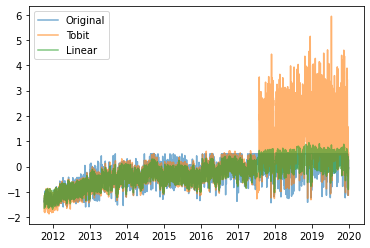

In [168]:
plt.plot(testdata["Energy (kWh)"], label = "Original", alpha = 0.6)
plt.plot(testdata.index,pred_tobit, label = "Tobit", alpha = 0.6)
plt.plot(testdata.index,pred, label = "Linear", alpha = 0.6)

plt.legend()
plt.show()

In [100]:
np.sqrt(mean_squared_error(df["Energy (kWh)"][(df.Label == 0.0)][5:],scaler_eng.inverse_transform(pred_tobit)))

28.590606295460017

In [63]:
np.sqrt(mean_squared_error(df["Energy (kWh)"][(df.Label == 0.0)][5:], pred))

100.08467705453879

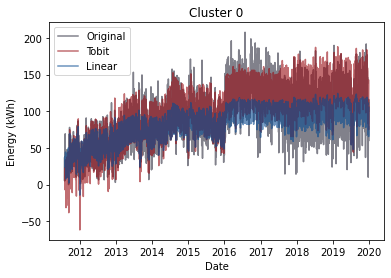

In [102]:
cmap = plt.cm.bone
rmap = plt.cm.Reds
bmap = plt.cm.Blues

plt.plot(df["Energy (kWh)"][df.Label == 0.0], label = "Original", alpha = 0.6, color=cmap(0.2))
plt.plot(testdata.index,scaler_eng.inverse_transform(pred_tobit), label = "Tobit", alpha = 0.6, color=rmap(0.9))
plt.plot(testdata.index,scaler_eng.inverse_transform(pred), label = "Linear", alpha = 0.6, color=bmap(0.9))
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.title("Cluster 0")
plt.legend()
plt.show()

In [324]:
r2_score(df["Energy (kWh)"][df.Label == 0.0][5:], pred_tobit)

0.5576782641226523

In [325]:
r2_score(df["Energy (kWh)"][df.Label == 0.0][5:], pred)

0.42260574711624244

In [28]:
from sklearn.metrics import mean_absolute_error



In [29]:
mean_absolute_error(df["Energy (kWh)"][df.Label == 0.0], pred_tobit)

0.3165387656320173

In [30]:
mean_absolute_error(df["Energy (kWh)"][df.Label == 0.0], pred)

0.31109770821282523

In [31]:
mean_squared_error(df["Energy (kWh)"][df.Label == 0.0], pred_tobit)

0.1738560036810394

In [32]:
mean_squared_error(df["Energy (kWh)"][df.Label == 0.0], pred)

0.16970687574924748